In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# ==============================================================================
# 1. CARREGAMENTO DO EXCEL (CAMINHO SOLICITADO)
# ==============================================================================
CAMINHO_ARQUIVO = os.path.join('..', 'data', 'BASE DE DADOS PEDE 2024 - DATATHON.xlsx')

print(f"Lendo arquivo Excel em: {CAMINHO_ARQUIVO}")

if not os.path.exists(CAMINHO_ARQUIVO):
    raise FileNotFoundError("ERRO: O arquivo não foi encontrado neste caminho. Verifique se a pasta 'data' está correta.")

# Lê todas as abas de uma vez
dict_abas = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=None)

# ==============================================================================
# 2. DEFINIÇÃO DOS MAPAS (SELEÇÃO CIRÚRGICA)
# ==============================================================================
# A lógica aqui é: A Chave é o nome no Excel, o Valor é o nome final padronizado.
# Só o que estiver nestes dicionários será levado para o final.

mapa_2022 = {
    'RA': 'RA', 'Fase': 'FASE', 'Gênero': 'GENERO', 'Idade 22': 'IDADE', 
    'Ano ingresso': 'ANO_INGRESSO',
    'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN',
    
    # Unificações solicitadas
    'Matem': 'NOTA_MAT', 
    'Portug': 'NOTA_PORT', 
    'Inglês': 'NOTA_ING',
    'Fase ideal': 'FASE_IDEAL', 
    'Defas': 'DEFASAGEM',
    
    # Apenas Pedra vigente (sem históricos)
    'Pedra 22': 'PEDRA'
}

mapa_2023 = {
    'RA': 'RA', 'Fase': 'FASE', 'Gênero': 'GENERO', 'Idade': 'IDADE', 
    'Ano ingresso': 'ANO_INGRESSO',
    'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN',
    
    'Mat': 'NOTA_MAT', 
    'Por': 'NOTA_PORT', 
    'Ing': 'NOTA_ING',
    'Fase Ideal': 'FASE_IDEAL', 
    'Defasagem': 'DEFASAGEM',
    
    'IPP': 'IPP', # Existe em 2023
    'Pedra 2023': 'PEDRA'
}

mapa_2024 = {
    'RA': 'RA', 'Fase': 'FASE', 'Gênero': 'GENERO', 'Idade': 'IDADE', 
    'Ano ingresso': 'ANO_INGRESSO',
    'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN',
    
    'Mat': 'NOTA_MAT', 
    'Por': 'NOTA_PORT', 
    'Ing': 'NOTA_ING',
    'Fase Ideal': 'FASE_IDEAL', 
    'Defasagem': 'DEFASAGEM',
    
    'IPP': 'IPP', # Existe em 2024
    'Pedra 2024': 'PEDRA'
}

# ==============================================================================
# 3. PROCESSAMENTO
# ==============================================================================
dfs_para_unir = []

for nome_aba, df in dict_abas.items():
    df_temp = df.copy()
    
    # 1. Identificar Ano e Mapa
    ano = None
    mapa_usado = None
    
    if "2022" in nome_aba: 
        ano = 2022; mapa_usado = mapa_2022
    elif "2023" in nome_aba: 
        ano = 2023; mapa_usado = mapa_2023
    elif "2024" in nome_aba: 
        ano = 2024; mapa_usado = mapa_2024
        
    if ano:
        print(f"Processando aba '{nome_aba}' como {ano}...")
        
        # 2. REMOÇÃO DE COLUNAS DUPLICADAS NO ORIGEM (Evita o InvalidIndexError)
        # Se houver duas colunas "Fase", mantém apenas a primeira antes de fazer qualquer coisa
        df_temp = df_temp.loc[:, ~df_temp.columns.duplicated()]
        
        # 3. Filtragem: Seleciona APENAS as colunas que estão no mapa
        # (Isso descarta automaticamente todo o resto que não queremos)
        colunas_existentes = [c for c in mapa_usado.keys() if c in df_temp.columns]
        df_limpo = df_temp[colunas_existentes].copy()
        
        # 4. Renomeação
        df_limpo.rename(columns=mapa_usado, inplace=True)
        
        # 5. Adiciona coluna de Ano
        df_limpo['ANO_DATATHON'] = ano
        
        # 6. Tratamento especial para IPP em 2022 (que não tem no mapa)
        if 'IPP' not in df_limpo.columns:
            df_limpo['IPP'] = np.nan
            
        dfs_para_unir.append(df_limpo)
    else:
        print(f"Aviso: Aba '{nome_aba}' ignorada.")

# ==============================================================================
# 4. UNIFICAÇÃO FINAL
# ==============================================================================
if dfs_para_unir:
    df_final = pd.concat(dfs_para_unir, ignore_index=True, sort=False)
    
    # Ordenação final das colunas para facilitar leitura
    ordem_colunas = [
        'ANO_DATATHON', 'RA', 'FASE', 'GENERO', 'IDADE', 'ANO_INGRESSO',
        'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP',
        'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING',
        'FASE_IDEAL', 'DEFASAGEM', 'PEDRA'
    ]
    
    # Filtra apenas as que existem (segurança)
    cols_finais = [c for c in ordem_colunas if c in df_final.columns]
    df_final = df_final[cols_finais]

    print("\n" + "="*40)
    print(" SUCESSO! DATASET UNIFICADO E LIMPO ")
    print("="*40)
    print(f"Total de Linhas: {df_final.shape[0]}")
    print(f"Colunas Finais: {df_final.columns.tolist()}")
    
    # Exibe amostra
    display(df_final.head())
    
    # Salva o resultado
    # df_final.to_excel('PEDE_PASSOS_DATASET_LIMPO.xlsx', index=False)
else:
    print("ERRO: Nenhuma aba foi processada. Verifique os nomes das abas no Excel.")

Lendo arquivo Excel em: ..\data\BASE DE DADOS PEDE 2024 - DATATHON.xlsx
Processando aba 'PEDE2022' como 2022...
Processando aba 'PEDE2023' como 2023...
Processando aba 'PEDE2024' como 2024...

 SUCESSO! DATASET UNIFICADO E LIMPO 
Total de Linhas: 3030
Colunas Finais: ['ANO_DATATHON', 'RA', 'FASE', 'GENERO', 'IDADE', 'ANO_INGRESSO', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP', 'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'FASE_IDEAL', 'DEFASAGEM', 'PEDRA']


,ANO_DATATHON,RA,FASE,GENERO,IDADE,ANO_INGRESSO,IAA,IEG,IPS,IDA,IPV,IAN,IPP,NOTA_MAT,NOTA_PORT,NOTA_ING,FASE_IDEAL,DEFASAGEM,PEDRA
0,2022,RA-1,7,Menina,19,2016,8.3,4.1,5.6,4.0,7.278,5.0,NaN,2.7,3.5,6.0,Fase 8 (Universitários),-1,Quartzo
1,2022,RA-2,7,Menina,17,2017,8.8,5.2,6.3,6.8,6.778,10.0,NaN,6.3,4.5,9.7,Fase 7 (3º EM),0,Ametista
2,2022,RA-3,7,Menina,17,2016,0.0,7.9,5.6,5.6,7.556,10.0,NaN,5.8,4.0,6.9,Fase 7 (3º EM),0,Ágata
3,2022,RA-4,7,Menino,17,2017,8.8,4.5,5.6,5.0,5.278,10.0,NaN,2.8,3.5,8.7,Fase 7 (3º EM),0,Quartzo
4,2022,RA-5,7,Menina,17,2016,7.9,8.6,5.6,5.2,7.389,10.0,NaN,7.0,2.9,5.7,Fase 7 (3º EM),0,Ametista


In [3]:
print("Informações do DataFrame:")
df_final.info()

print("\nContagem de valores únicos por coluna:")
for column in df_final.columns:
    unique_count = df_final[column].nunique()
    print(f"'{column}': {unique_count} valores únicos")

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ANO_DATATHON  3030 non-null   int64  
 1   RA            3030 non-null   object 
 2   FASE          3030 non-null   object 
 3   GENERO        3030 non-null   object 
 4   IDADE         3030 non-null   object 
 5   ANO_INGRESSO  3030 non-null   int64  
 6   IAA           2865 non-null   float64
 7   IEG           2954 non-null   float64
 8   IPS           2859 non-null   float64
 9   IDA           2852 non-null   float64
 10  IPV           2852 non-null   float64
 11  IAN           3030 non-null   float64
 12  IPP           1992 non-null   float64
 13  NOTA_MAT      2846 non-null   float64
 14  NOTA_PORT     2845 non-null   float64
 15  NOTA_ING      1091 non-null   float64
 16  FASE_IDEAL    3030 non-null   object 
 17  DEFASAGEM     3030 non-null   int64  
 18  PE

# 📚 Dicionário de Dados - Passos Mágicos

Este documento descreve as variáveis presentes no dataset unificado (`PEDE_PASSOS_DATASET_LIMPO.csv`), consolidando os dados de 2022, 2023 e 2024.

---

### 1. Identificação e Controle
Variáveis utilizadas para rastreabilidade e organização temporal dos registros.

* **`ANO_DATATHON`**: Ano de referência do registro (Safra). Indica se o dado pertence ao ciclo de 2022, 2023 ou 2024.
* **`RA`**: Registro Acadêmico. Identificador único e anonimizado do aluno. Permite acompanhar a evolução do mesmo estudante ao longo dos anos.

### 2. Perfil Demográfico e Escolar
Características individuais e educacionais do aluno.

* **`GENERO`**: Sexo do aluno.
* **`IDADE`**: Idade do aluno no ano de referência.
* **`ANO_INGRESSO`**: Ano em que o aluno iniciou sua trajetória na Associação Passos Mágicos.
* **`FASE`**: Turma ou etapa atual em que o aluno está matriculado na ONG (ex: Fase 1, Alpha).
* **`FASE_IDEAL`**: A fase em que o aluno *deveria* estar, considerando sua idade ou ano escolar regular.
* **`DEFASAGEM`**: Diferença entre a `FASE` atual e a `FASE_IDEAL`. Valores negativos indicam atraso escolar.

### 3. Indicadores Psicossociais (Soft Skills)
Métricas que compõem a dimensão psicossocial e comportamental do INDE (Índice de Desenvolvimento Educacional).

* **`IAA` (Índice de Autoavaliação)**: Nota atribuída pelo próprio aluno sobre seu desempenho, sentimentos e autoconfiança.
* **`IEG` (Índice de Engajamento)**: Mede o comprometimento com as atividades (entrega de lições, presença, participação).
* **`IPS` (Índice Psicossocial)**: Avaliação realizada por psicólogos sobre aspectos emocionais, sociais e familiares.
* **`IPV` (Índice de Ponto de Virada)**: Avalia o potencial de transformação social e a resiliência do aluno frente a vulnerabilidades.
* **`IAN` (Indicador de Adequação de Nível)**: Mede o grau de adequação do conhecimento do aluno em relação ao esperado para sua fase.
* **`IPP` (Índice Psicopedagógico)**: Avaliação de aspectos de aprendizagem e possíveis dificuldades cognitivas. *(Nota: Este indicador não foi coletado em 2022, apresentando valores nulos nesse ano).*

### 4. Desempenho Acadêmico (Hard Skills)
Notas e indicadores de performance escolar.

* **`IDA` (Índice de Aprendizagem)**: Indicador consolidado de desempenho escolar (média ponderada das matérias).
* **`NOTA_MAT`**: Nota de Matemática.
* **`NOTA_PORT`**: Nota de Português.
* **`NOTA_ING`**: Nota de Inglês.

### 5. Variável Alvo (Target)
A classificação final do aluno, que determina a renovação de bolsas e benefícios.

* **`PEDRA`**: Classificação baseada no INDE Geral do aluno.
    * 💎 **Quartzo**: Nível Inicial / Atenção.
    * 💎 **Ágata**: Nível Básico / Em desenvolvimento.
    * 💎 **Ametista**: Nível Intermediário / Bom desempenho.
    * 💎 **Topázio**: Nível Avançado / Excelente desempenho.

In [4]:
correcoes = {
    'Agata': 'Ágata',
}
df_final['PEDRA'] = df_final['PEDRA'].replace(correcoes)

# 3. Filtragem (Manter apenas as pedras oficiais)
pedras_oficiais = ['Ágata', 'Quartzo', 'Topázio', 'Ametista']

# Identificar o que será removido (apenas para log)
lixo = df_final[~df_final['PEDRA'].isin(pedras_oficiais)]['PEDRA'].unique()
print(f"\nRemovendo registros com os valores: {lixo}")
# APLICAR O FILTRO (O "delete a linha" acontece aqui)
df_final = df_final[df_final['PEDRA'].isin(pedras_oficiais)].copy()

print(f"\nTotal de linhas DEPOIS da limpeza: {df_final.shape[0]}")


Removendo registros com os valores: [nan 'INCLUIR']

Total de linhas DEPOIS da limpeza: 2845


=== 1. VISÃO GERAL DO DATASET ===
Dimensões: (2845, 19)


,ANO_DATATHON,RA,FASE,GENERO,IDADE,ANO_INGRESSO,IAA,IEG,IPS,IDA,IPV,IAN,IPP,NOTA_MAT,NOTA_PORT,NOTA_ING,FASE_IDEAL,DEFASAGEM,PEDRA
0,2022,RA-1,7,Menina,19,2016,8.3,4.1,5.6,4.0,7.278,5.0,NaN,2.7,3.5,6.0,Fase 8 (Universitários),-1,Quartzo
1,2022,RA-2,7,Menina,17,2017,8.8,5.2,6.3,6.8,6.778,10.0,NaN,6.3,4.5,9.7,Fase 7 (3º EM),0,Ametista
2,2022,RA-3,7,Menina,17,2016,0.0,7.9,5.6,5.6,7.556,10.0,NaN,5.8,4.0,6.9,Fase 7 (3º EM),0,Ágata
3,2022,RA-4,7,Menino,17,2017,8.8,4.5,5.6,5.0,5.278,10.0,NaN,2.8,3.5,8.7,Fase 7 (3º EM),0,Quartzo
4,2022,RA-5,7,Menina,17,2016,7.9,8.6,5.6,5.2,7.389,10.0,NaN,7.0,2.9,5.7,Fase 7 (3º EM),0,Ametista



=== 2. ANÁLISE DE DADOS FALTANTES (NULOS) ===


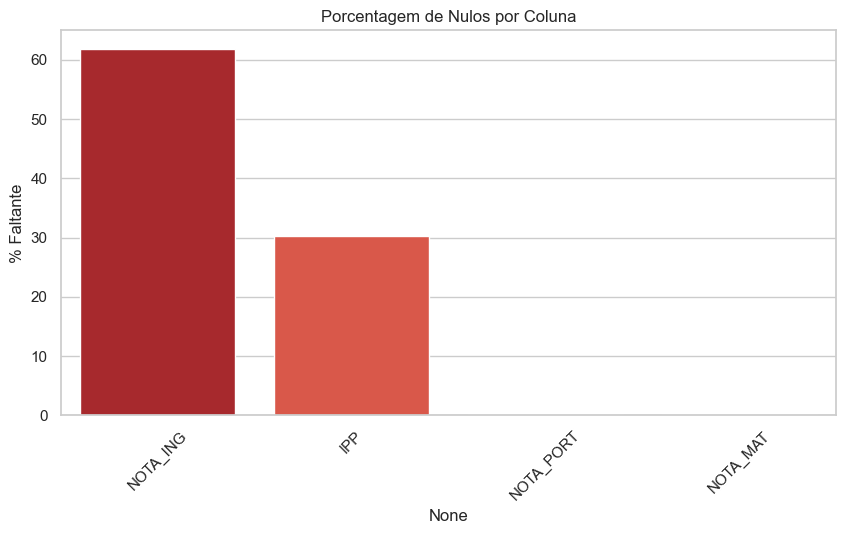

Colunas Críticas (>20% nulos):
['NOTA_ING', 'IPP']


In [5]:
# Configuração de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=== 1. VISÃO GERAL DO DATASET ===")
print(f"Dimensões: {df_final.shape}")
display(df_final.head())

print("\n=== 2. ANÁLISE DE DADOS FALTANTES (NULOS) ===")
# Calcula % de nulos
nulos = df_final.isnull().sum() / len(df_final) * 100
nulos = nulos[nulos > 0].sort_values(ascending=False)

if not nulos.empty:
    plt.figure(figsize=(10, 5))
    
    # --- CORREÇÃO AQUI ---
    # Adicionamos hue=nulos.index e legend=False
    ax = sns.barplot(
        x=nulos.index, 
        y=nulos.values, 
        hue=nulos.index,  # A cor muda conforme a coluna (eixo X)
        legend=False,     # Não precisamos de legenda pois o eixo X já explica
        palette="Reds_r"
    )
    # ---------------------
    
    plt.title("Porcentagem de Nulos por Coluna")
    plt.ylabel("% Faltante")
    plt.xticks(rotation=45)
    plt.show()
    print("Colunas Críticas (>20% nulos):")
    print(nulos[nulos > 20].index.tolist())
else:
    print("Incrível! Zero nulos encontrados.")

In [6]:
# --- BLOCO DE TRATAMENTO DE NULOS E REMOÇÃO DE REDUNDÂNCIA ---

# 1. Tratando o IPP (Com Flag + Mediana)
# PASSO A: Criar a flag ANTES de preencher os nulos
# 0 = O dado não existia (ex: ano de 2022); 1 = O dado foi coletado.
df_final['IPP_COLETADO'] = df_final['IPP'].notnull().astype(int)

# PASSO B: Calcular a mediana dos valores existentes
mediana_ipp = df_final['IPP'].median()

# PASSO C: Preencher os nulos com a mediana
df_final['IPP'] = df_final['IPP'].fillna(mediana_ipp)

print("Flag 'IPP_COLETADO' criada com sucesso.")
print(f"Nulos de IPP preenchidos com a mediana: {mediana_ipp}")

# 2. Tratando Inglês (Criando flag e preenchendo com 0)
# Cria uma coluna para avisar o modelo: "Esse aluno tem aula de inglês?"
df_final['TEM_INGLES'] = df_final['NOTA_ING'].notnull().astype(int)
# Agora preenche a nota com 0 (seguro, pois a flag avisa que ele não tem aula)
df_final['NOTA_ING'] = df_final['NOTA_ING'].fillna(0)

# 3. Tratando Matemática e Português (Preenchendo falhas com a Mediana)
# Essas matérias são obrigatórias, nulo aqui é erro de cadastro.
for materia in ['NOTA_MAT', 'NOTA_PORT']:
    mediana_materia = df_final[materia].median()
    df_final[materia] = df_final[materia].fillna(mediana_materia)

# 4. Removendo o IDA (Decisão de Arquitetura)
# Removemos para evitar multicolinearidade, já que ele é redundante com as notas.
if 'IDA' in df_final.columns:
    df_final = df_final.drop(columns=['IDA'])
    print("Coluna 'IDA' removida com sucesso (Redundância).")

print("\nVerificação Final de Nulos (Deve estar tudo zerado):")
# Verificamos apenas as colunas que ficaram
cols_verificar = ['IPP', 'NOTA_ING', 'NOTA_MAT', 'NOTA_PORT', 'TEM_INGLES']
print(df_final[cols_verificar].isnull().sum())

Flag 'IPP_COLETADO' criada com sucesso.
Nulos de IPP preenchidos com a mediana: 7.5
Coluna 'IDA' removida com sucesso (Redundância).

Verificação Final de Nulos (Deve estar tudo zerado):
IPP           0
NOTA_ING      0
NOTA_MAT      0
NOTA_PORT     0
TEM_INGLES    0
dtype: int64


In [7]:
# Verificando os valores "sujos" na coluna IDADE
# O sort_values ajuda a colocar textos e números em ordem para facilitar a leitura

print("Valores únicos na coluna IDADE (Antes do tratamento):")
# Convertemos para string apenas para visualizar tudo junto, sem erro de sort
print(sorted(df_final['IDADE'].astype(str).unique()))

# Se quiser ver quantas vezes cada "sujeira" aparece:
print("\nContagem de valores (Top 20):")
print(df_final['IDADE'].value_counts().head(20))

Valores únicos na coluna IDADE (Antes do tratamento):
['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1900-01-07 00:00:00', '1900-01-08 00:00:00', '1900-01-09 00:00:00', '1900-01-10 00:00:00', '1900-01-11 00:00:00', '1900-01-12 00:00:00', '1900-01-13 00:00:00', '1900-01-14 00:00:00', '1900-01-15 00:00:00', '1900-01-16 00:00:00', '1900-01-17 00:00:00', '1900-01-18 00:00:00', '1900-01-19 00:00:00', '1900-01-20 00:00:00', '20', '21', '22', '7', '8', '9']

Contagem de valores (Top 20):
IDADE
10                     321
12                     316
11                     311
13                     268
9                      263
14                     235
15                     198
8                      180
16                     164
17                     129
1900-01-11 00:00:00     56
7                       47
1900-01-12 00:00:00     47
1900-01-09 00:00:00     43
1900-01-14 00:00:00     42
1900-01-10 00:00:00     36
18                      34
1900-01-08 00:00:00     34
1900-01

In [8]:
# --- ETAPA 1: CORREÇÃO CIRÚRGICA DA IDADE ---

# Primeiro, garantimos que tudo é string para analisar
df_final['IDADE'] = df_final['IDADE'].astype(str)

# Filtro para achar as datas do Excel (começam com "1900-")
mask_datas = df_final['IDADE'].str.startswith('1900-')

# Para essas linhas, convertemos para data e extraímos apenas o DIA
# Ex: "1900-01-11" vira 11
df_final.loc[mask_datas, 'IDADE'] = pd.to_datetime(df_final.loc[mask_datas, 'IDADE'], errors='coerce').dt.day

# Agora que convertemos as datas em dias, transformamos tudo em número
df_final['IDADE'] = pd.to_numeric(df_final['IDADE'], errors='coerce')

# Preenchemos eventuais nulos reais (agora devem ser poucos) com a mediana
mediana_idade = df_final['IDADE'].median()
df_final['IDADE'] = df_final['IDADE'].fillna(mediana_idade)

# --- VERIFICAÇÃO ---
print("Valores únicos de IDADE após correção:")
print(sorted(df_final['IDADE'].unique()))
print(f"\nTem algum nulo sobrando? {df_final['IDADE'].isnull().sum()}")

Valores únicos de IDADE após correção:
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

Tem algum nulo sobrando? 0


In [9]:
# --- BLOCO DE ENCODING FINAL (PEDRA, GENERO, FASE, FASE_IDEAL, RA) ---

# 1. PEDRA (Variável Alvo) -> Texto para Número
# .str.strip() garante que não haja espaços invisíveis quebrando o map
mapa_pedra = {
    'Quartzo': 0,
    'Ágata': 1,
    'Ametista': 2,
    'Topázio': 3
}
df_final['PEDRA'] = df_final['PEDRA'].astype(str).str.strip().map(mapa_pedra)

# 2. GÊNERO -> Binário (0 ou 1)
mapa_genero = {
    'Feminino': 1, 'Menina': 1,
    'Masculino': 0, 'Menino': 0
}
df_final['GENERO'] = df_final['GENERO'].astype(str).str.strip().map(mapa_genero)

# 3. FASE -> Extraindo o número (Ex: "Fase 1" vira 1)
df_final['FASE'] = df_final['FASE'].astype(str).str.extract(r'(\d+)', expand=False)
df_final['FASE'] = pd.to_numeric(df_final['FASE'], errors='coerce').fillna(0).astype(int)

# 4. FASE_IDEAL (NOVO) -> Mesmo processo da FASE
df_final['FASE_IDEAL'] = df_final['FASE_IDEAL'].astype(str).str.extract(r'(\d+)', expand=False)
df_final['FASE_IDEAL'] = pd.to_numeric(df_final['FASE_IDEAL'], errors='coerce').fillna(0).astype(int)

# 5. RA -> Limpeza total (Remove traços, pontos e letras)
# Regex r'\D' significa "tudo que NÃO é dígito"
df_final['RA'] = df_final['RA'].astype(str).str.replace(r'\D', '', regex=True)
df_final['RA'] = pd.to_numeric(df_final['RA'], errors='coerce')

# --- VERIFICAÇÃO ---
print("Transformação concluída!")
cols_verificar = ['PEDRA', 'GENERO', 'FASE', 'FASE_IDEAL', 'RA']
print(df_final[cols_verificar].head())

print("\nTipos dos dados (Devem ser todos numéricos/float/int):")
print(df_final[cols_verificar].dtypes)

Transformação concluída!
   PEDRA  GENERO  FASE  FASE_IDEAL  RA
0      0       1     7           8   1
1      2       1     7           7   2
2      1       1     7           7   3
3      0       0     7           7   4
4      2       1     7           7   5

Tipos dos dados (Devem ser todos numéricos/float/int):
PEDRA         int64
GENERO        int64
FASE          int32
FASE_IDEAL    int32
RA            int64
dtype: object


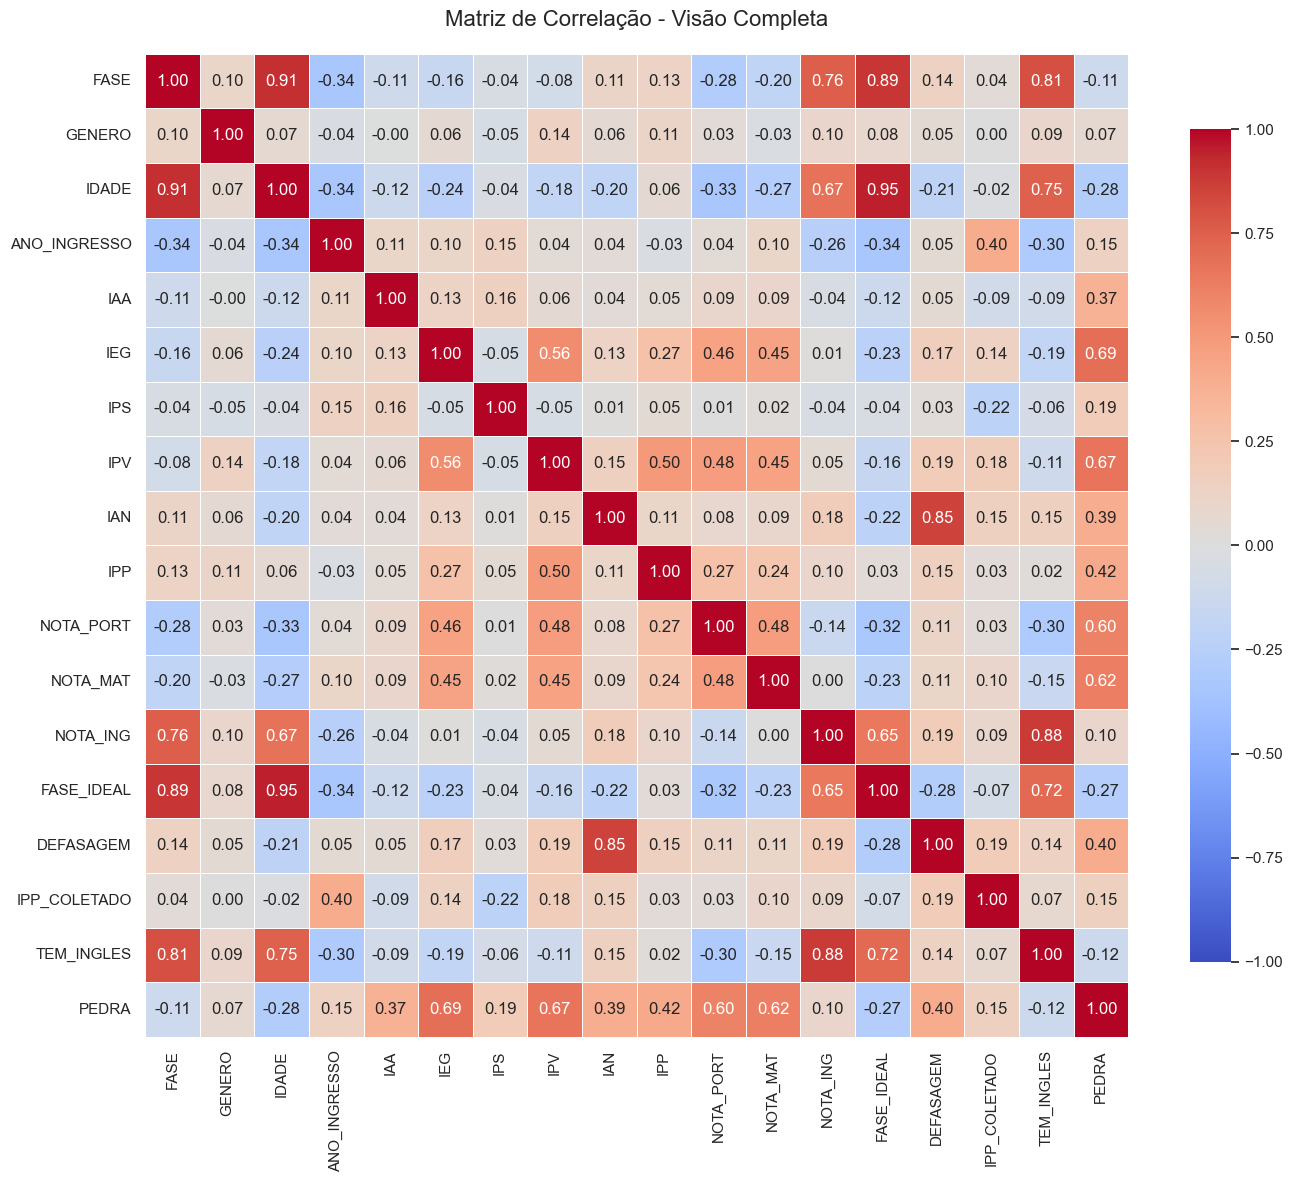

In [10]:
# --- BLOCO DE VISUALIZAÇÃO GERAL (ANÁLISE PRÉ-MODELAGEM) ---
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 1. Definindo as variáveis que entrarão no modelo
# (Certifique-se que todas essas colunas existem no seu df_final)
cols_analise = [
    'FASE', 'GENERO', 'IDADE','ANO_INGRESSO',
    'IAA', 'IEG', 'IPS', 'IPV', 'IAN', 'IPP',
    'NOTA_PORT', 'NOTA_MAT', 'NOTA_ING',
    'FASE_IDEAL', 'DEFASAGEM', 'IPP_COLETADO',
    'TEM_INGLES', 'PEDRA'
]

# Filtrar apenas as que existem (segurança contra erros de digitação)
cols_existentes = [c for c in cols_analise if c in df_final.columns]

# --- A. GRÁFICO DE CORRELAÇÃO COMPLETO ---
plt.figure(figsize=(14, 12))
plt.title("Matriz de Correlação - Visão Completa", fontsize=16, pad=20)

# Calculando correlação (numeric_only=True garante que só pega números)
corr = df_final[cols_existentes].corr(numeric_only=True)

# Plotando o Heatmap (sem máscara, quadrado inteiro)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

plt.tight_layout()
plt.show()

In [11]:
# --- AJUSTE FINO (BASEADO NA MATRIZ DE CORRELAÇÃO) ---

# 1. Removendo FASE_IDEAL
# Motivo: Correlação quase 1.0 com IDADE. É redundante.
if 'FASE_IDEAL' in df_final.columns:
    df_final = df_final.drop(columns=['FASE_IDEAL'])
    print("Coluna 'FASE_IDEAL' removida (Informação já contida em IDADE).")

Coluna 'FASE_IDEAL' removida (Informação já contida em IDADE).


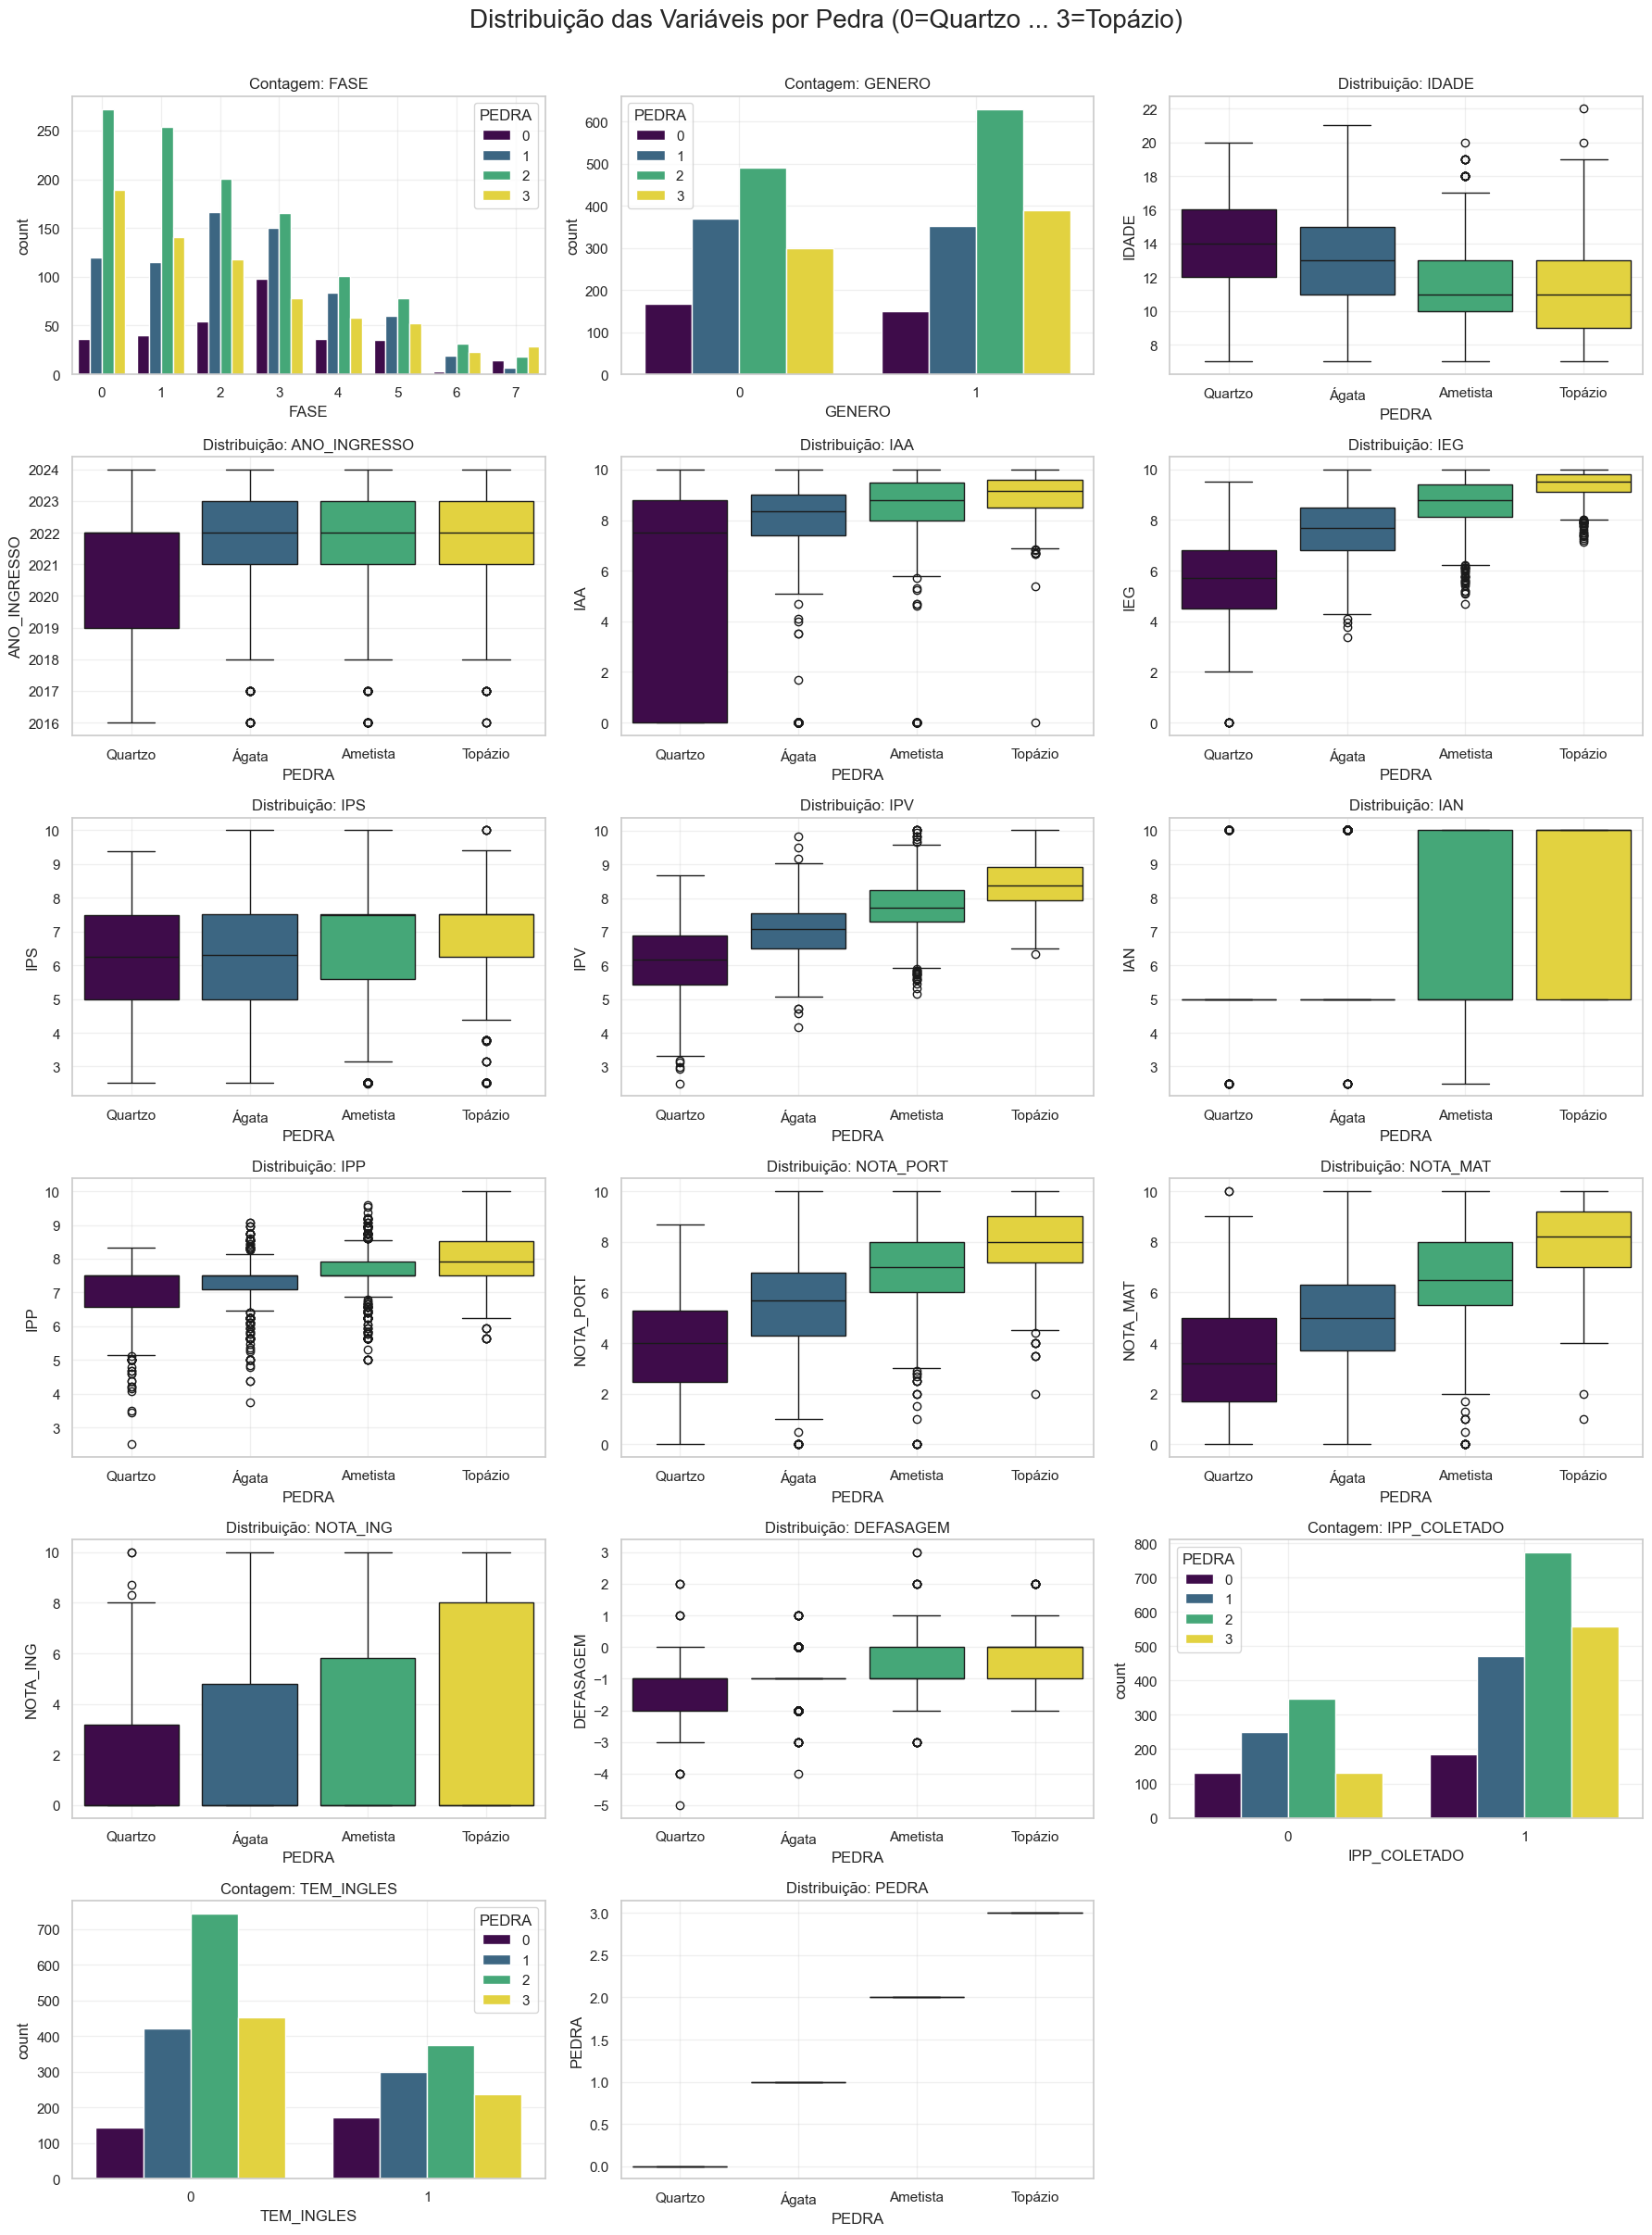

In [12]:
# --- B. BOXPLOTS DE TODAS AS VARIÁVEIS (Cruzando com a Pedra) ---
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo colunas que devem ser tratadas como Categóricas (Barras)
cols_categoricas = ['GENERO', 'TEM_INGLES', 'IPP_COLETADO', 'FASE']

# --- CORREÇÃO PRINCIPAL ---
# Filtramos a lista 'cols_existentes' para manter APENAS o que ainda está no df_final.
# Isso remove automaticamente a 'FASE_IDEAL' ou qualquer outra que você tenha excluído.
cols_existentes = [c for c in cols_existentes if c in df_final.columns]

# Vamos criar um grid dinâmico de gráficos
num_vars = len(cols_existentes)
cols_grid = 3  # 3 gráficos por linha
rows_grid = math.ceil(num_vars / cols_grid)

plt.figure(figsize=(18, rows_grid * 4)) # Altura ajustável
plt.suptitle("Distribuição das Variáveis por Pedra (0=Quartzo ... 3=Topázio)", fontsize=20, y=1.005)

# Mapeamento para os rótulos do eixo X ficarem bonitos
labels_pedra = {0: 'Quartzo', 1: 'Ágata', 2: 'Ametista', 3: 'Topázio'}

for i, col in enumerate(cols_existentes):
    ax = plt.subplot(rows_grid, cols_grid, i + 1)
    
    # Verifica se a coluna atual é categórica
    if col in cols_categoricas:
        # Gráfico de Contagem (Barras)
        sns.countplot(data=df_final, x=col, hue='PEDRA', palette='viridis', ax=ax)
        ax.set_title(f"Contagem: {col}")
        
    else:
        # Boxplot normal para variáveis contínuas
        # hue='PEDRA' e legend=False evitam o erro futuro do Seaborn
        sns.boxplot(data=df_final, x='PEDRA', y=col, hue='PEDRA', palette='viridis', legend=False, ax=ax)
        ax.set_title(f"Distribuição: {col}")
        
        # Fixar os ticks antes de mudar os labels
        valores_unicos_pedra = sorted(df_final['PEDRA'].unique())
        ax.set_xticks(valores_unicos_pedra) 
        ax.set_xticklabels([labels_pedra.get(x, x) for x in valores_unicos_pedra])

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

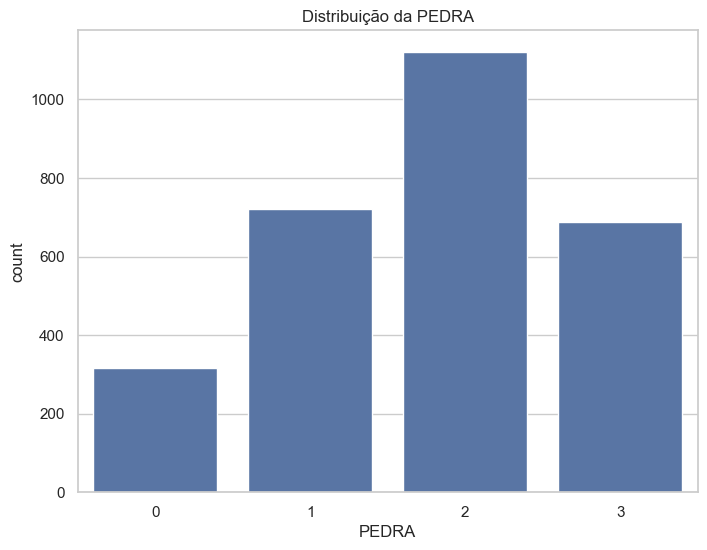

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_final, x='PEDRA', order=sorted(df_final['PEDRA'].unique()))
plt.title('Distribuição da PEDRA')
plt.show()

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split




# Criando o dataset de modelagem (usando df_final do seu notebook)
df_modelagem = df_final.copy()

# 2. Preparação dos dados
X = df_modelagem.drop(['PEDRA', 'RA', 'ANO_DATATHON'], axis=1)
y = df_modelagem['PEDRA']

# Split de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicação do SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Verificação
print("--- Resultado do Balanceamento ---")
print(pd.Series(y_resampled).value_counts())
print(f"\nVariáveis utilizadas no modelo (Total: {len(X.columns)}):")
print(X.columns.tolist())

--- Resultado do Balanceamento ---
PEDRA
0    896
2    896
3    896
1    896
Name: count, dtype: int64

Variáveis utilizadas no modelo (Total: 16):
['FASE', 'GENERO', 'IDADE', 'ANO_INGRESSO', 'IAA', 'IEG', 'IPS', 'IPV', 'IAN', 'IPP', 'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'DEFASAGEM', 'IPP_COLETADO', 'TEM_INGLES']


In [15]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, balanced_accuracy_score, roc_auc_score)

# 1. Definindo a lista de modelos (Agora com MLP)
modelos = {
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    
    # --- NOVO MODELO ADICIONADO ---
    "MLP Classifier": MLPClassifier(
        hidden_layer_sizes=(100, 50), # Duas camadas ocultas
        max_iter=1000,                # Mais iterações para garantir convergência
        activation='relu',            # Função de ativação padrão
        solver='adam',                # Otimizador padrão
        random_state=42
    )
}

# 2. Loop de avaliação
resultados = []

print("🚀 Iniciando o duelo de modelos (incluindo Redes Neurais)...")

for nome, modelo in modelos.items():
    # Treinamento com dados balanceados
    # Nota: O MLP é muito sensível à escala. Certifique-se que X_resampled também esteja escalado
    modelo.fit(X_resampled, y_resampled)
    
    # Previsão de classes e de probabilidades
    y_pred = modelo.predict(X_test_scaled)
    y_probs = modelo.predict_proba(X_test_scaled)
    
    # Cálculo das métricas
    metrics = {
        "Modelo": nome,
        "Acurácia": accuracy_score(y_test, y_pred),
        "Acurácia Balanceada": balanced_accuracy_score(y_test, y_pred),
        "F1-Score (Macro)": f1_score(y_test, y_pred, average='macro'),
        "ROC AUC (Macro)": roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro'),
        "Precision (Macro)": precision_score(y_test, y_pred, average='macro'),
        "Recall (Macro)": recall_score(y_test, y_pred, average='macro')
    }
    
    resultados.append(metrics)
    print(f"✅ {nome} finalizado.")

# 3. Exibindo o Ranking ordenado pelo F1-Score e AUC
df_comparacao = pd.DataFrame(resultados).sort_values(by=["F1-Score (Macro)", "ROC AUC (Macro)"], ascending=False)

# Formatação opcional para deixar a tabela mais bonita no Jupyter
display(df_comparacao)

🚀 Iniciando o duelo de modelos (incluindo Redes Neurais)...
✅ XGBoost finalizado.
✅ Random Forest finalizado.
✅ Logistic Regression finalizado.
✅ SVM finalizado.
✅ KNN finalizado.
✅ MLP Classifier finalizado.


,Modelo,Acurácia,Acurácia Balanceada,F1-Score (Macro),ROC AUC (Macro),Precision (Macro),Recall (Macro)
2,Logistic Regression,0.949033,0.955875,0.946088,0.997010,0.937998,0.955875
5,MLP Classifier,0.950791,0.945582,0.943152,0.996975,0.940855,0.945582
3,SVM,0.920914,0.925514,0.917796,0.993727,0.911066,0.925514
0,XGBoost,0.887522,0.896270,0.891123,0.984320,0.886544,0.896270
1,Random Forest,0.884007,0.890787,0.889568,0.979861,0.888390,0.890787
4,KNN,0.773286,0.806386,0.779413,0.941053,0.765154,0.806386


In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # <--- Importação do MLP
import numpy as np

# 1. Definição dos Espaços de Busca (Grids)
param_grids = {
    "Logistic Regression": {
        'C': np.logspace(-3, 3, 7),
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'] 
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly']
    },
    # --- Grid Específico para MLP ---
    "MLP Classifier": {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50, 50)], # Diferentes arquiteturas
        'activation': ['tanh', 'relu'],          # Funções de ativação clássicas
        'alpha': [0.0001, 0.001, 0.01],          # Regularização L2 (ajuda a evitar overfitting)
        'learning_rate_init': [0.001, 0.01]      # Velocidade de aprendizado inicial
    }
}

# 2. Executando a Otimização
modelos_otimizados = {}

# Definimos os modelos base (MLP adicionado com mais iterações para garantir convergência)
instancias_base = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42) # <--- Instância Base
}

print("⌛ Iniciando otimização (Logistic Regression, SVM e MLP)...")

# Lista atualizada de modelos para rodar
modelos_para_testar = ["Logistic Regression", "SVM", "MLP Classifier"]

for nome in modelos_para_testar:
    print(f"🔎 Otimizando {nome}...")
    
    search = RandomizedSearchCV(
        estimator=instancias_base[nome],
        param_distributions=param_grids[nome],
        n_iter=15,              # Testa 15 combinações aleatórias
        cv=3,                   # Validação cruzada em 3 dobras
        scoring='f1_macro',     # Foco no F1-Score Macro
        n_jobs=-1,              # Usa todos os núcleos
        random_state=42
    )
    
    # Treinando com os dados balanceados (resampled)
    search.fit(X_resampled, y_resampled)
    modelos_otimizados[nome] = search.best_estimator_
    
    print(f"✅ Melhor F1-Score (Treino-CV) para {nome}: {search.best_score_:.4f}")
    print(f"📌 Melhores Parâmetros: {search.best_params_}\n")

print("--- Otimização Concluída! ---")

⌛ Iniciando otimização (Logistic Regression, SVM e MLP)...
🔎 Otimizando Logistic Regression...


c:\Users\T-GAMER\Desktop\Python\Fase 5\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=15. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Melhor F1-Score (Treino-CV) para Logistic Regression: 0.9668
📌 Melhores Parâmetros: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10.0}

🔎 Otimizando SVM...
✅ Melhor F1-Score (Treino-CV) para SVM: 0.9725
📌 Melhores Parâmetros: {'kernel': 'rbf', 'gamma': 0.01, 'C': 100}

🔎 Otimizando MLP Classifier...
✅ Melhor F1-Score (Treino-CV) para MLP Classifier: 0.9754
📌 Melhores Parâmetros: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}

--- Otimização Concluída! ---


--- RELATÓRIO FINAL (DADOS DE TESTE) - MLP ---
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        63
           1       0.94      0.94      0.94       144
           2       0.97      0.96      0.96       224
           3       0.97      0.97      0.97       138

    accuracy                           0.96       569
   macro avg       0.95      0.96      0.95       569
weighted avg       0.96      0.96      0.96       569



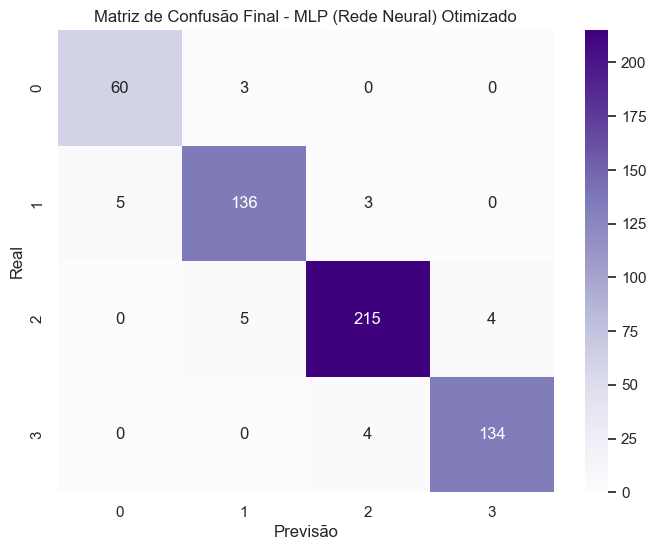

✅ Modelo MLP e Scaler salvos com sucesso!


In [17]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Recuperando o modelo campeão (MLP) do dicionário
# Nota: A chave deve ser exatamente a mesma usada no loop anterior ("MLP Classifier")
modelo_final = modelos_otimizados["MLP Classifier"]

# 2. Avaliando nos dados de TESTE
y_pred_final = modelo_final.predict(X_test_scaled)

print("--- RELATÓRIO FINAL (DADOS DE TESTE) - MLP ---")
print(classification_report(y_test, y_pred_final))

# 3. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', # Mudei para Roxo (Purples) para diferenciar
            xticklabels=modelo_final.classes_, 
            yticklabels=modelo_final.classes_)

plt.title('Matriz de Confusão Final - MLP (Rede Neural) Otimizado')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

# 4. SALVANDO PARA O DEPLOY (API)
# Salvando especificamente com o nome _mlp para diferenciar
joblib.dump(modelo_final, 'modelo_passos_magicos_mlp.joblib')
joblib.dump(scaler, 'scaler_passos_magicos.joblib')

print("✅ Modelo MLP e Scaler salvos com sucesso!")

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Criando o dataset de modelagem (usando df_final do seu notebook)
df_modelagem = df_final.copy()

# --- ALTERAÇÃO PRINCIPAL ---
# Definimos a lista estrita de colunas "observáveis"
colunas_selecionadas = ['IDADE', 'FASE', 'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'GENERO']

# Selecionamos apenas essas colunas para o X
X = df_modelagem[colunas_selecionadas]
y = df_modelagem['PEDRA']

# Split de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicação do SMOTE
# (Opcional: Como a acurácia vai cair, o SMOTE pode ajudar nas classes menores como Ágata)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Verificação
print("--- Resultado do Balanceamento ---")
print(pd.Series(y_resampled).value_counts())

print(f"\nVariáveis utilizadas no modelo (Total: {len(X.columns)}):")
print(X.columns.tolist())

--- Resultado do Balanceamento ---
PEDRA
0    896
2    896
3    896
1    896
Name: count, dtype: int64

Variáveis utilizadas no modelo (Total: 6):
['IDADE', 'FASE', 'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'GENERO']


In [19]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, balanced_accuracy_score, roc_auc_score)

# 1. Definindo a lista de modelos (Agora com MLP)
modelos = {
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    
    # --- NOVO MODELO ADICIONADO ---
    "MLP Classifier": MLPClassifier(
        hidden_layer_sizes=(100, 50), # Duas camadas ocultas
        max_iter=1000,                # Mais iterações para garantir convergência
        activation='relu',            # Função de ativação padrão
        solver='adam',                # Otimizador padrão
        random_state=42
    )
}

# 2. Loop de avaliação
resultados = []

print("🚀 Iniciando o duelo de modelos (incluindo Redes Neurais)...")

for nome, modelo in modelos.items():
    # Treinamento com dados balanceados
    # Nota: O MLP é muito sensível à escala. Certifique-se que X_resampled também esteja escalado
    modelo.fit(X_resampled, y_resampled)
    
    # Previsão de classes e de probabilidades
    y_pred = modelo.predict(X_test_scaled)
    y_probs = modelo.predict_proba(X_test_scaled)
    
    # Cálculo das métricas
    metrics = {
        "Modelo": nome,
        "Acurácia": accuracy_score(y_test, y_pred),
        "Acurácia Balanceada": balanced_accuracy_score(y_test, y_pred),
        "F1-Score (Macro)": f1_score(y_test, y_pred, average='macro'),
        "ROC AUC (Macro)": roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro'),
        "Precision (Macro)": precision_score(y_test, y_pred, average='macro'),
        "Recall (Macro)": recall_score(y_test, y_pred, average='macro')
    }
    
    resultados.append(metrics)
    print(f"✅ {nome} finalizado.")

# 3. Exibindo o Ranking ordenado pelo F1-Score e AUC
df_comparacao = pd.DataFrame(resultados).sort_values(by=["F1-Score (Macro)", "ROC AUC (Macro)"], ascending=False)

# Formatação opcional para deixar a tabela mais bonita no Jupyter
display(df_comparacao)

🚀 Iniciando o duelo de modelos (incluindo Redes Neurais)...
✅ XGBoost finalizado.
✅ Random Forest finalizado.
✅ Logistic Regression finalizado.
✅ SVM finalizado.
✅ KNN finalizado.
✅ MLP Classifier finalizado.


,Modelo,Acurácia,Acurácia Balanceada,F1-Score (Macro),ROC AUC (Macro),Precision (Macro),Recall (Macro)
2,Logistic Regression,0.597540,0.645132,0.602556,0.844646,0.588142,0.645132
3,SVM,0.579965,0.623803,0.583585,0.846538,0.572206,0.623803
0,XGBoost,0.569420,0.583565,0.575955,0.831682,0.572445,0.583565
5,MLP Classifier,0.557118,0.580104,0.559431,0.820599,0.555344,0.580104
1,Random Forest,0.546573,0.555184,0.548035,0.818912,0.544332,0.555184
4,KNN,0.507909,0.551318,0.511997,0.770784,0.498096,0.551318


In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier # <--- Não esqueça de instalar: pip install xgboost
import numpy as np

# 1. Grids (Mantidos iguais)
param_grids = {
    "Logistic Regression": {
        'C': np.logspace(-3, 3, 7),
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'] 
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly']
    },
    "MLP Classifier": {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50, 50)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    },
    # Grid do XGBoost
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# 2. Instâncias Base (AQUI ESTÁ A CORREÇÃO DO MLP)
instancias_base = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    
    # --- CORREÇÃO: Aumentei max_iter para 3000 para evitar o ConvergenceWarning ---
    "MLP Classifier": MLPClassifier(max_iter=3000, random_state=42), 
    
    "XGBoost": XGBClassifier(
        objective='multi:softprob', 
        eval_metric='mlogloss', 
        use_label_encoder=False, 
        random_state=42
    )
}

print("⌛ Iniciando otimização com correção de convergência...")

# Lista completa
modelos_para_testar = ["Logistic Regression", "SVM", "MLP Classifier", "XGBoost"]
modelos_otimizados = {}

for nome in modelos_para_testar:
    print(f"🔎 Otimizando {nome}...")
    
    search = RandomizedSearchCV(
        estimator=instancias_base[nome],
        param_distributions=param_grids[nome],
        n_iter=15, 
        cv=3, 
        scoring='f1_macro', 
        n_jobs=-1, 
        random_state=42
    )
    
    search.fit(X_resampled, y_resampled)
    modelos_otimizados[nome] = search.best_estimator_
    
    print(f"✅ Melhor F1-Score (Treino-CV) para {nome}: {search.best_score_:.4f}")
    print(f"📌 Melhores Parâmetros: {search.best_params_}\n")

print("--- Otimização Concluída! ---")

⌛ Iniciando otimização com correção de convergência...
🔎 Otimizando Logistic Regression...
✅ Melhor F1-Score (Treino-CV) para Logistic Regression: 0.6273
📌 Melhores Parâmetros: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}

🔎 Otimizando SVM...


c:\Users\T-GAMER\Desktop\Python\Fase 5\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=15. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Melhor F1-Score (Treino-CV) para SVM: 0.6794
📌 Melhores Parâmetros: {'kernel': 'rbf', 'gamma': 'scale', 'C': 100}

🔎 Otimizando MLP Classifier...
✅ Melhor F1-Score (Treino-CV) para MLP Classifier: 0.7276
📌 Melhores Parâmetros: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh'}

🔎 Otimizando XGBoost...
✅ Melhor F1-Score (Treino-CV) para XGBoost: 0.7003
📌 Melhores Parâmetros: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}

--- Otimização Concluída! ---


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Criando o dataset de modelagem (usando df_final do seu notebook)
df_modelagem = df_final.copy()

# --- ALTERAÇÃO PRINCIPAL ---
# Definimos a lista estrita de colunas "observáveis"
colunas_selecionadas = [
    'IDADE', 'GENERO', 'ANO_INGRESSO', 'FASE', 'DEFASAGEM',  # Contexto
    'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING',                     # Acadêmico (Hard Skills)
    'IEG', 'IPS', 'IAA', 'IPP'                               # Comportamental (Soft Skills)
]

# Selecionamos apenas essas colunas para o X
X = df_modelagem[colunas_selecionadas]
y = df_modelagem['PEDRA']

# Split de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicação do SMOTE
# (Opcional: Como a acurácia vai cair, o SMOTE pode ajudar nas classes menores como Ágata)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Verificação
print("--- Resultado do Balanceamento ---")
print(pd.Series(y_resampled).value_counts())

print(f"\nVariáveis utilizadas no modelo (Total: {len(X.columns)}):")
print(X.columns.tolist())

--- Resultado do Balanceamento ---
PEDRA
0    896
2    896
3    896
1    896
Name: count, dtype: int64

Variáveis utilizadas no modelo (Total: 12):
['IDADE', 'GENERO', 'ANO_INGRESSO', 'FASE', 'DEFASAGEM', 'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'IEG', 'IPS', 'IAA', 'IPP']


In [22]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, balanced_accuracy_score, roc_auc_score)

# 1. Definindo a lista de modelos (Agora com MLP)
modelos = {
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    
    # --- NOVO MODELO ADICIONADO ---
    "MLP Classifier": MLPClassifier(
        hidden_layer_sizes=(100, 50), # Duas camadas ocultas
        max_iter=1000,                # Mais iterações para garantir convergência
        activation='relu',            # Função de ativação padrão
        solver='adam',                # Otimizador padrão
        random_state=42
    )
}

# 2. Loop de avaliação
resultados = []

print("🚀 Iniciando o duelo de modelos (incluindo Redes Neurais)...")

for nome, modelo in modelos.items():
    # Treinamento com dados balanceados
    # Nota: O MLP é muito sensível à escala. Certifique-se que X_resampled também esteja escalado
    modelo.fit(X_resampled, y_resampled)
    
    # Previsão de classes e de probabilidades
    y_pred = modelo.predict(X_test_scaled)
    y_probs = modelo.predict_proba(X_test_scaled)
    
    # Cálculo das métricas
    metrics = {
        "Modelo": nome,
        "Acurácia": accuracy_score(y_test, y_pred),
        "Acurácia Balanceada": balanced_accuracy_score(y_test, y_pred),
        "F1-Score (Macro)": f1_score(y_test, y_pred, average='macro'),
        "ROC AUC (Macro)": roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro'),
        "Precision (Macro)": precision_score(y_test, y_pred, average='macro'),
        "Recall (Macro)": recall_score(y_test, y_pred, average='macro')
    }
    
    resultados.append(metrics)
    print(f"✅ {nome} finalizado.")

# 3. Exibindo o Ranking ordenado pelo F1-Score e AUC
df_comparacao = pd.DataFrame(resultados).sort_values(by=["F1-Score (Macro)", "ROC AUC (Macro)"], ascending=False)

# Formatação opcional para deixar a tabela mais bonita no Jupyter
display(df_comparacao)

🚀 Iniciando o duelo de modelos (incluindo Redes Neurais)...
✅ XGBoost finalizado.
✅ Random Forest finalizado.
✅ Logistic Regression finalizado.
✅ SVM finalizado.
✅ KNN finalizado.
✅ MLP Classifier finalizado.


,Modelo,Acurácia,Acurácia Balanceada,F1-Score (Macro),ROC AUC (Macro),Precision (Macro),Recall (Macro)
2,Logistic Regression,0.861160,0.877448,0.863333,0.978154,0.854512,0.877448
3,SVM,0.855888,0.875712,0.858181,0.976446,0.846689,0.875712
0,XGBoost,0.841828,0.847034,0.842686,0.972665,0.839572,0.847034
5,MLP Classifier,0.843585,0.850684,0.839322,0.970583,0.831198,0.850684
1,Random Forest,0.818981,0.822253,0.825940,0.966105,0.831537,0.822253
4,KNN,0.745167,0.771615,0.741515,0.924553,0.728044,0.771615


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier # <--- Não esqueça de instalar: pip install xgboost
import numpy as np

# 1. Grids (Mantidos iguais)
param_grids = {
    "Logistic Regression": {
        'C': np.logspace(-3, 3, 7),
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'] 
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly']
    },
    "MLP Classifier": {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50, 50)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    },
    # Grid do XGBoost
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# 2. Instâncias Base (AQUI ESTÁ A CORREÇÃO DO MLP)
instancias_base = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    
    # --- CORREÇÃO: Aumentei max_iter para 3000 para evitar o ConvergenceWarning ---
    "MLP Classifier": MLPClassifier(max_iter=3000, random_state=42), 
    
    "XGBoost": XGBClassifier(
        objective='multi:softprob', 
        eval_metric='mlogloss', 
        use_label_encoder=False, 
        random_state=42
    )
}

print("⌛ Iniciando otimização com correção de convergência...")

# Lista completa
modelos_para_testar = ["Logistic Regression", "SVM", "MLP Classifier", "XGBoost"]
modelos_otimizados = {}

for nome in modelos_para_testar:
    print(f"🔎 Otimizando {nome}...")
    
    search = RandomizedSearchCV(
        estimator=instancias_base[nome],
        param_distributions=param_grids[nome],
        n_iter=15, 
        cv=3, 
        scoring='f1_macro', 
        n_jobs=-1, 
        random_state=42
    )
    
    search.fit(X_resampled, y_resampled)
    modelos_otimizados[nome] = search.best_estimator_
    
    print(f"✅ Melhor F1-Score (Treino-CV) para {nome}: {search.best_score_:.4f}")
    print(f"📌 Melhores Parâmetros: {search.best_params_}\n")

print("--- Otimização Concluída! ---")

⌛ Iniciando otimização com correção de convergência...
🔎 Otimizando Logistic Regression...
✅ Melhor F1-Score (Treino-CV) para Logistic Regression: 0.8744
📌 Melhores Parâmetros: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10.0}

🔎 Otimizando SVM...


c:\Users\T-GAMER\Desktop\Python\Fase 5\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=15. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Melhor F1-Score (Treino-CV) para SVM: 0.9090
📌 Melhores Parâmetros: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

🔎 Otimizando MLP Classifier...
✅ Melhor F1-Score (Treino-CV) para MLP Classifier: 0.9130
📌 Melhores Parâmetros: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'relu'}

🔎 Otimizando XGBoost...
✅ Melhor F1-Score (Treino-CV) para XGBoost: 0.9034
📌 Melhores Parâmetros: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}

--- Otimização Concluída! ---


--- RESULTADO FINAL NO TESTE ---
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        63
           1       0.81      0.86      0.84       144
           2       0.92      0.79      0.85       224
           3       0.84      0.95      0.89       138

    accuracy                           0.86       569
   macro avg       0.85      0.88      0.86       569
weighted avg       0.86      0.86      0.86       569



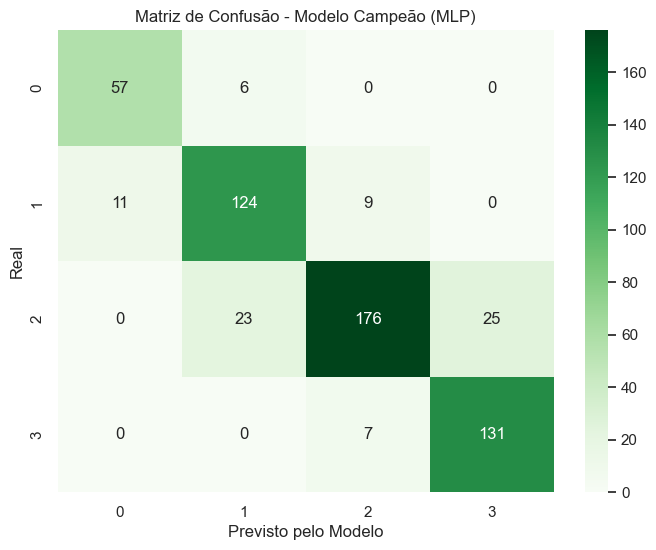

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Recriar o campeão com os melhores hiperparâmetros encontrados
# {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'relu'}
mlp_final = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    alpha=0.01,
    learning_rate_init=0.001,
    max_iter=2000,
    random_state=42
)

# 2. Treinar no X_train completo (ou X_resampled se usou SMOTE)
mlp_final.fit(X_resampled, y_resampled)

# 3. Prever no X_test (que o modelo NUNCA viu)
y_pred_final = mlp_final.predict(X_test_scaled)

# 4. Mostrar a verdade nua e crua
print("--- RESULTADO FINAL NO TESTE ---")
print(classification_report(y_test, y_pred_final))

# Matriz visual
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - Modelo Campeão (MLP)')
plt.ylabel('Real')
plt.xlabel('Previsto pelo Modelo')
plt.show()